In [1]:
import os
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from IPython.display import Audio
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq
from scipy import signal, stats

In [2]:
%matplotlib inline

In [3]:
# some global variables
filepath = '/home/lagvna/slncs/'
mp3_name = 'drilling.mp3'
wav_name = 'drilling.wav'
sample_frequency = 44100
chunk_size = 44100

In [4]:
# converting mp3 to mono wav
sound = AudioSegment.from_mp3(filepath + mp3_name)
sound = sound.set_channels(1)
sound.export(filepath + wav_name, format="wav")

<_io.BufferedRandom name='/home/lagvna/slncs/drilling.wav'>

# EDA

In [5]:
rate, data = wav.read('drilling.wav')

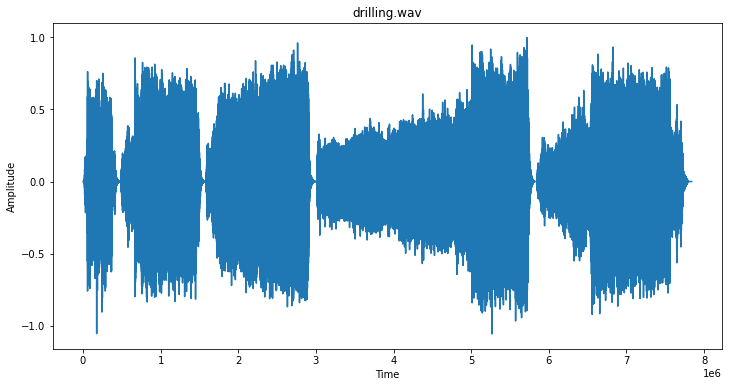

In [6]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(data/np.max(data))
plt.title(wav_name)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [7]:
len(data)/rate

177.79045351473923

/home/lagvna/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


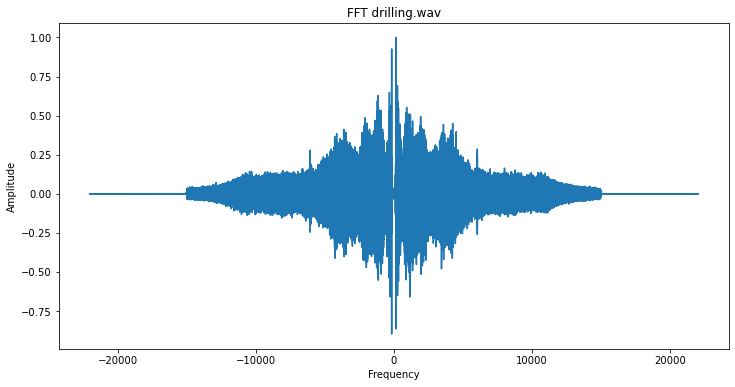

In [8]:
# fft
yf = fft(data)
yf = yf/np.max(yf)
xf = fftfreq(len(data), 1 / rate)

plt.figure(figsize=(12, 6))
plt.plot(xf, yf)
plt.title("FFT " + wav_name)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [9]:
stats.describe(xf)

DescribeResult(nobs=7840559, minmax=(-22049.99718770052, 22049.99718770052), mean=8.344766853360832e-13, variance=162067520.67040122, skewness=1.240473918383452e-16, kurtosis=-1.200000000000043)

In [10]:
stats.describe(yf)

DescribeResult(nobs=7840559, minmax=((-0.8970946748657357+0.39917940269558333j), (0.9999999999999999+0j)), mean=(6.856315448559889e-21-3.908933918081637e-21j), variance=0.0041327822809332235, skewness=(-4.341980328282563e-15+21.12850814108369j), kurtosis=(10759.695175082345+5.956104848576945e-12j))

In [11]:
# stft
f, t, Zxx = signal.stft(data, nperseg=512)

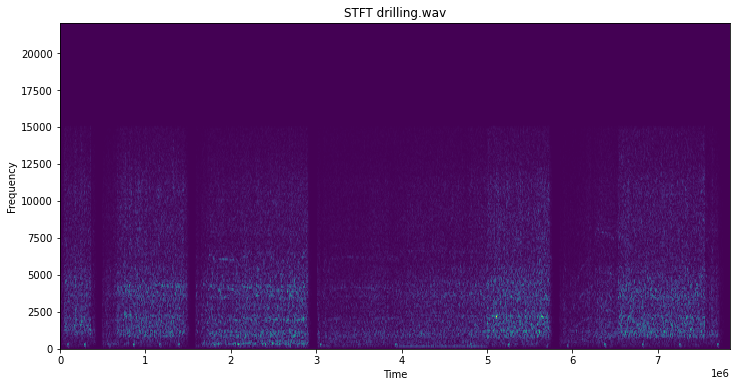

In [12]:
plt.figure(figsize=(12,6))
plt.pcolormesh(t, f*sample_frequency, np.abs(Zxx), vmin=0, shading='flat')
plt.title("STFT "+wav_name)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

# Data preprocessing

In [13]:
# divide data into chunks with possible zero value padding in the last chunk
def divide_data(recording, chunk_size):
    remainder = len(recording) % chunk_size
    padding_size = chunk_size - remainder
    padding_vector = np.zeros(padding_size)
    padded_recording = np.append(recording, padding_vector)
    chunks = np.split(padded_recording, len(padded_recording)/chunk_size)
    
    return chunks

In [14]:
def fftransform(recording_chunks):
    fft_chunks = []
    for c in recording_chunks:
        fft_chunk = fft(c)
        full_fft_chunk = np.concatenate((np.real(fft_chunk), np.imag(fft_chunk)))
        fft_chunks.append(full_fft_chunk)
    return fft_chunks

In [15]:
def inv_fftransform(fq_chunks):
    chunks = []
    for c in fq_chunks:
        midpoint = c.shape[0] / 2
        real_chunk = c[0:int(midpoint)]
        imag_chunk = c[int(midpoint):]
        # amplitude represented as a complex number corresponding to the frequency
        full_chunk = real_chunk + 1.0j * imag_chunk
        time_chunk = ifft(full_chunk)
        chunks.append(time_chunk)
    return chunks

In [16]:
normalized_data = data / 32767.0
data_chunks = divide_data(normalized_data, chunk_size)
#print(data_chunks)
X = fftransform(data_chunks)
Y = fftransform(data_chunks[1:])
print(np.shape(X))
print(np.shape(Y))

(178, 88200)
(177, 88200)


#### LSTM requires a 3D input in the form of (samples, timesteps, features) ->
https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/

In [17]:
# further divide chunks into equal timesteps (to fulfill requirements for LSTM input) with possible padding
timestep = 10

In [18]:
# padding with zero vectors at the end, for an equal split
while len(X)%timestep != 0:
    X.append(np.zeros(np.shape(X)[1]))
    
while len(Y)%timestep != 0:
    Y.append(np.zeros(np.shape(Y)[1]))

In [19]:
# turning into np array to split examples equally into timesteps, then going back to a list
X = np.array(X)
tmp_x = np.split(X, X.shape[0]/timestep)
x_train = np.stack(tmp_x, axis = 0)

Y = np.array(Y)
tmp_y = np.split(Y, Y.shape[0]/timestep)
y_train = np.stack(tmp_y, axis = 0)

In [20]:
print(np.shape(x_train))
print(np.shape(y_train))

(18, 10, 88200)
(18, 10, 88200)


# Model design and training

In [21]:
h_units = 1024

examples = (np.shape(x_train))[0]
t_steps = (np.shape(x_train))[1]
frequencies = (np.shape(x_train))[2]

model = Sequential()
model.add(TimeDistributed(Dense(h_units, input_shape=(frequencies, ))))
model.add(Bidirectional(LSTM(h_units, input_shape=(h_units, ), return_sequences=True)))
#model.add(Bidirectional(LSTM(h_units, input_shape=(h_units, ), return_sequences=True)))
#model.add(Bidirectional(LSTM(h_units, input_shape=(h_units, ), return_sequences=True)))
model.add(TimeDistributed(Dense(frequencies, input_shape=(h_units, ))))
#adam = Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
model.build((examples, t_steps, frequencies))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (18, 10, 1024)            90317824  
_________________________________________________________________
bidirectional (Bidirectional (18, 10, 2048)            16785408  
_________________________________________________________________
time_distributed_1 (TimeDist (18, 10, 88200)           180721800 
Total params: 287,825,032
Trainable params: 287,825,032
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(x_train, y_train, batch_size=10, epochs=5, verbose=1, validation_split=0.0)

Epoch 1/5
2/2 [==============================] - 3s 2s/step - loss: 360.4768
Epoch 2/5
2/2 [==============================] - 3s 1s/step - loss: 360.3577
Epoch 3/5
2/2 [==============================] - 3s 2s/step - loss: 359.7029
Epoch 4/5
2/2 [==============================] - 3s 1s/step - loss: 358.9149
Epoch 5/5
2/2 [==============================] - 3s 1s/step - loss: 358.1080


# Audio generation

In [30]:
seed = x_train[1]
gen_length = 2
# 1 sample with a no of timesteps and corresponding no of features
seed = np.reshape(seed, (1, seed.shape[0], seed.shape[1]))

output = []

for i in range(gen_length):
    generated_piece = model.predict(seed)

    if i == 0:
        for j in range(generated_piece.shape[1]):
            output.append(generated_piece[0][j].copy())
    else:
        new_seed = generated_piece[0][generated_piece.shape[1]-1]
        new_seed = np.reshape(new_seed, (1, 1, new_seed.shape[0]))
        seed = np.concatenate((seed, new_seed), axis=1)
        output.append(generated_piece[0][generated_piece.shape[1]-1].copy())

In [31]:
gen_file_path = '/home/lagvna/slncs/gen_sound.wav'
inv_output = inv_fftransform(output)
gen_file = np.concatenate(inv_output)
final_file = gen_file * 32767.0
final_file = final_file.astype('int16')
wav.write(gen_file_path, sample_frequency, final_file)

<ipython-input-31-8632cf519293>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  final_file = final_file.astype('int16')


In [32]:
Audio(gen_file_path)